In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

### Fetch peak predictions

In [2]:
tf_name = "MAX"
predictions_path = "/users/amtseng/tfmodisco/results/peak_predictions/{0}/{0}_peak_prediction_performance.h5".format(tf_name)

In [3]:
pred_reader = h5py.File(predictions_path, "r")

### Plotting profiles

In [4]:
def plot_profiles(pred_profs, true_profs, title=None):
    """
    Plots the given profiles.
    Both arguments should be T x O x 2 NumPy arrays, where the subarrays are the
    tracks for the plus and minus strand, for each task.
    """
    num_tasks, prof_length = pred_profs.shape[0], pred_profs.shape[1]
    fig, ax = plt.subplots(num_tasks, figsize=(15, num_tasks * 2))
    if num_tasks == 1:
        ax = [ax]
    for i in range(num_tasks):
        ax[i].plot(true_profs[i,:,0], color="royalblue", alpha=0.5)
        ax[i].plot(-true_profs[i,:,1], color="goldenrod", alpha=0.5)
        ax[i].plot(pred_profs[i,:,0], color="darkslateblue")
        ax[i].plot(-pred_profs[i,:,1], color="darkorange")
    if title:
        fig.suptitle(title)
    plt.show()

In [5]:
def plot_prediction(pred_reader, fold, example_index):
    """
    From the HDF5 reader, fold, and index of example within the fold,
    plots the profiles using `plot_profiles`.
    """
    coord = pred_reader[fold]["coords"]
    chrom = coord["coords_chrom"][example_index].decode()
    start = coord["coords_start"][example_index]
    end = coord["coords_end"][example_index]
    print("%s:%d-%d" % (chrom, start, end))
    
    log_pred_profs = pred_reader[fold]["predictions"]["log_pred_profs"][example_index]
    true_profs = pred_reader[fold]["predictions"]["true_profs"][example_index]
    
    pred_profs = np.exp(log_pred_profs) * np.sum(true_profs, axis=1, keepdims=True)
    plot_profiles(pred_profs, true_profs)

### Pick best predictions and view

In [6]:
def rank_best_predictions_over_one_fold(pred_reader, fold):
    """
    From a single fold, computes the normalized NLL profile loss over
    all examples, and returns an N x 3 object array, where each of the
    rows is: fold, index of example in fold, normalized NLL
    The array is sorted in increasing order (best to worst) by the
    normalized NLL. For multiple tasks, the NLL is averaged over all
    tasks.
    """
    nlls = pred_reader[fold]["performance"]["nll"][:]  # Shape: N x T
    counts = pred_reader[fold]["predictions"]["true_counts"][:]  # Shape: N x T x 2
    counts = np.sum(counts, axis=2)  # Shape: N x T
    num_seqs = counts.shape[0]
    
    # Normalize NLLs by counts, keeping 0 where there are no real counts
    zero_mask = counts == 0
    nlls[zero_mask] = 0
    counts[zero_mask] = 1
    norm_nlls = nlls / counts
    
    # Average normalized NLLs over tasks
    norm_nlls_avg = np.mean(norm_nlls, axis=1)  # Shape: N
    
    result = np.empty((num_seqs, 3), dtype=object)
    result[:, 0] = fold
    result[:, 1] = np.arange(num_seqs)
    result[:, 2] = norm_nlls_avg
    
    # Sort result by normalized NLL
    inds = np.argsort(norm_nlls_avg)
    return result[inds]

In [7]:
def rank_best_predictions_over_all_folds(pred_reader):
    """
    From all folds, computes the normalized NLL profile loss over
    all examples, and returns an N x 3 object array, where each of the
    rows is: fold, index of example in fold, normalized NLL
    The array is sorted in increasing order (best to worst) by the
    normalized NLL. For multiple tasks, the NLL is averaged over all
    tasks.
    """
    folds = list(pred_reader.keys())
    fold_results = []
    for fold in folds:
        fold_results.append(rank_best_predictions_over_one_fold(pred_reader, fold))
    
    result = np.concatenate(fold_results)
    inds = np.argsort(result[:, 2])
    return result[inds]

In [8]:
def plot_best_unique_intervals(pred_reader, sorted_peak_inds, num_to_plot):
    """
    Plots the top `num_to_plot` intervals, taking only unique ones
    that don't overlap at all. `sorted_peak_inds` must be a result of
    `rank_best_predictions_over...`.
    """
    seen = np.empty((0, 3), dtype=object)
    next_index = 0
    num_found = 0
    while num_found < num_to_plot and next_index < len(sorted_peak_inds):
        fold, example_index, _ = sorted_peak_inds[next_index]
        coord = pred_reader[fold]["coords"]
        chrom = coord["coords_chrom"][example_index].decode()
        start = coord["coords_start"][example_index]
        end = coord["coords_end"][example_index]
        mask = (seen[:, 0] == chrom) & (seen[:, 1] < end) & (seen[:, 2] > start)
        if not np.any(mask):
            plot_prediction(pred_reader, fold, example_index)
            seen = np.concatenate([seen, np.array([[chrom, start, end]], dtype=object)])
            num_found += 1
        next_index += 1

In [9]:
sorted_peak_inds = rank_best_predictions_over_all_folds(pred_reader)

chr1:38011809-38013155


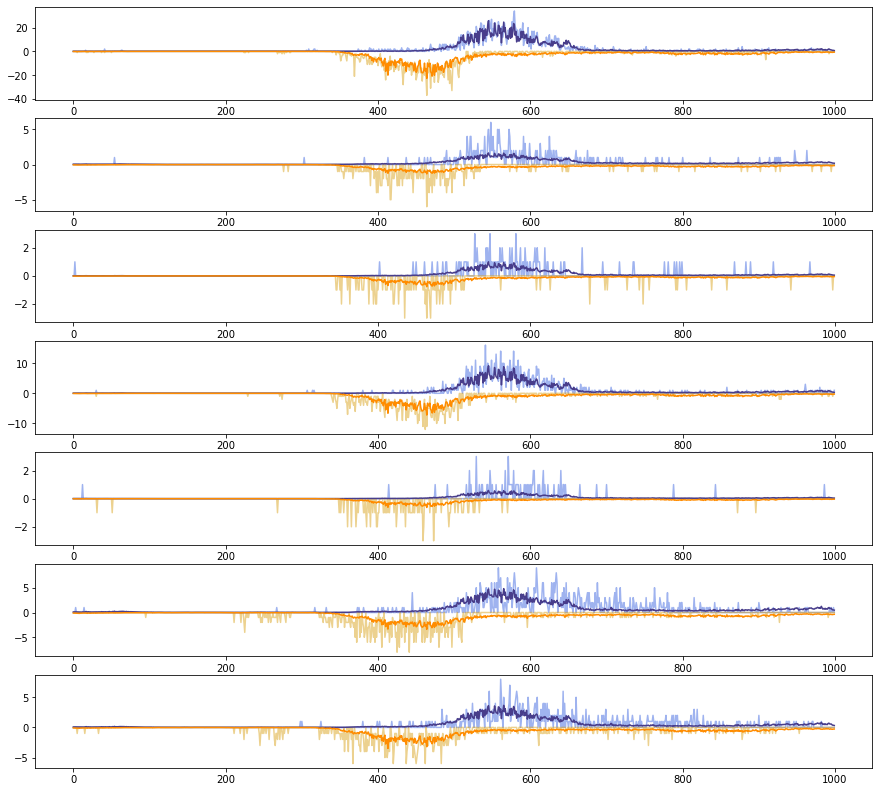

chr17:44069995-44071341


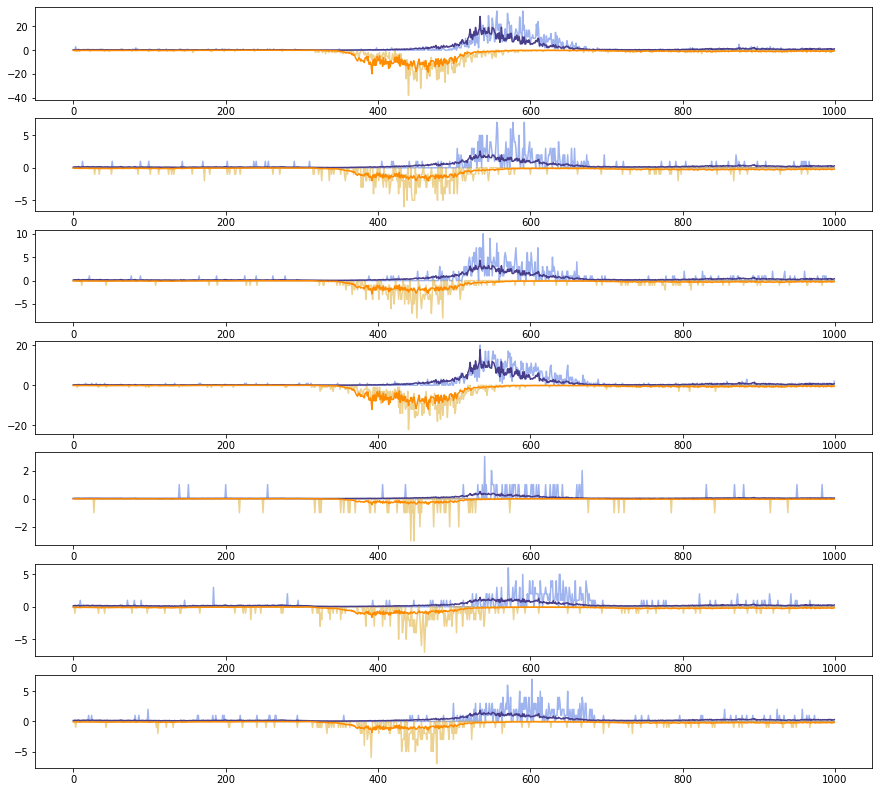

chr10:69179526-69180872


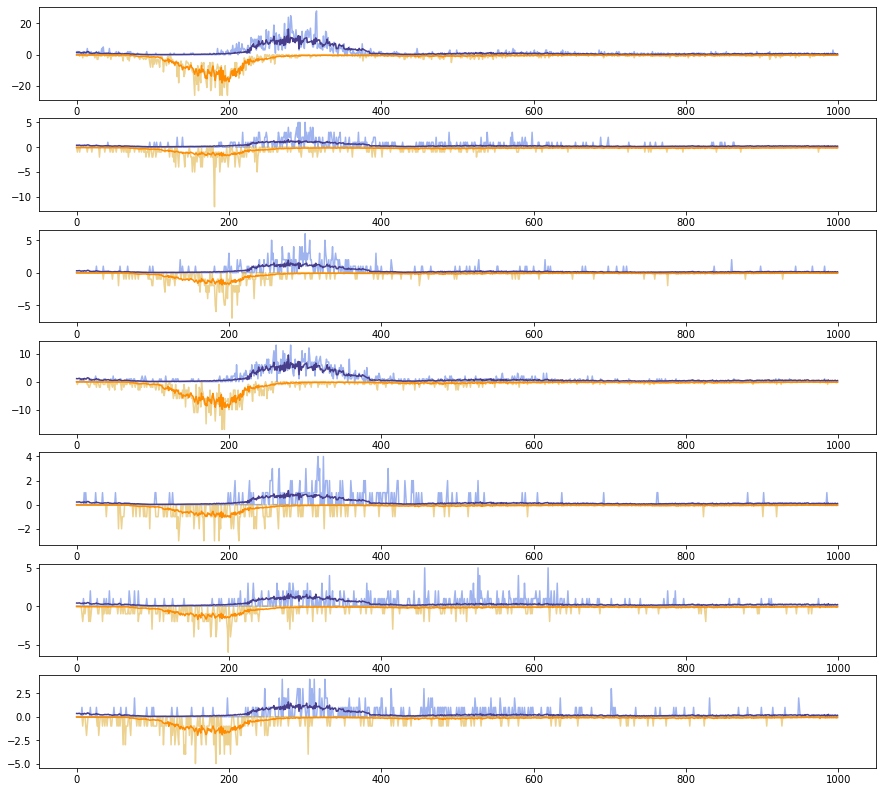

chr9:37119446-37120792


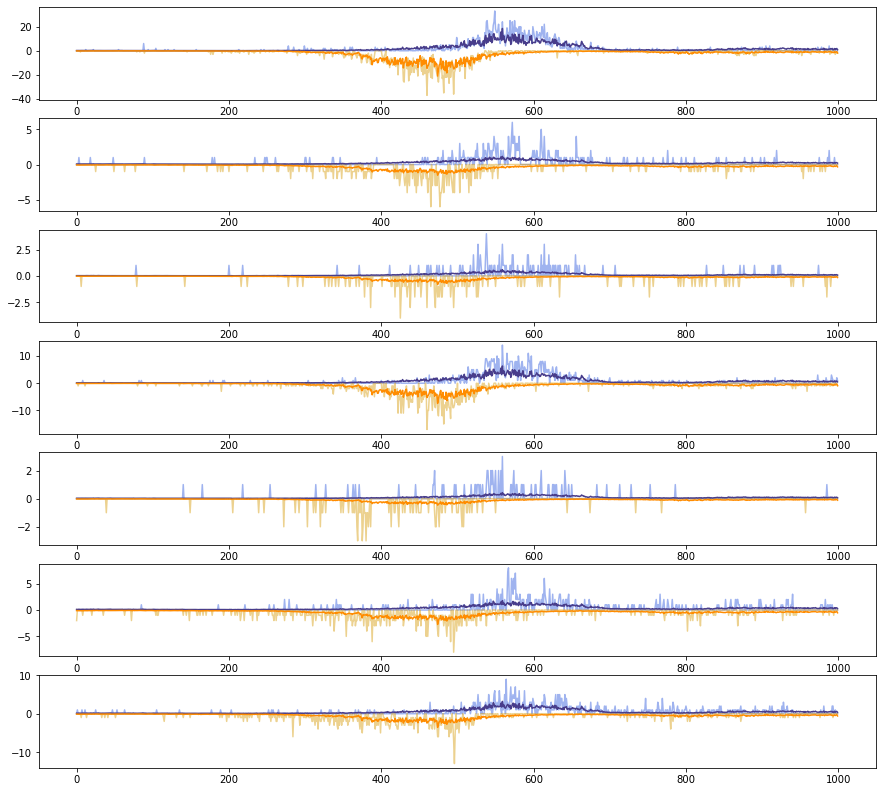

chr2:86440040-86441386


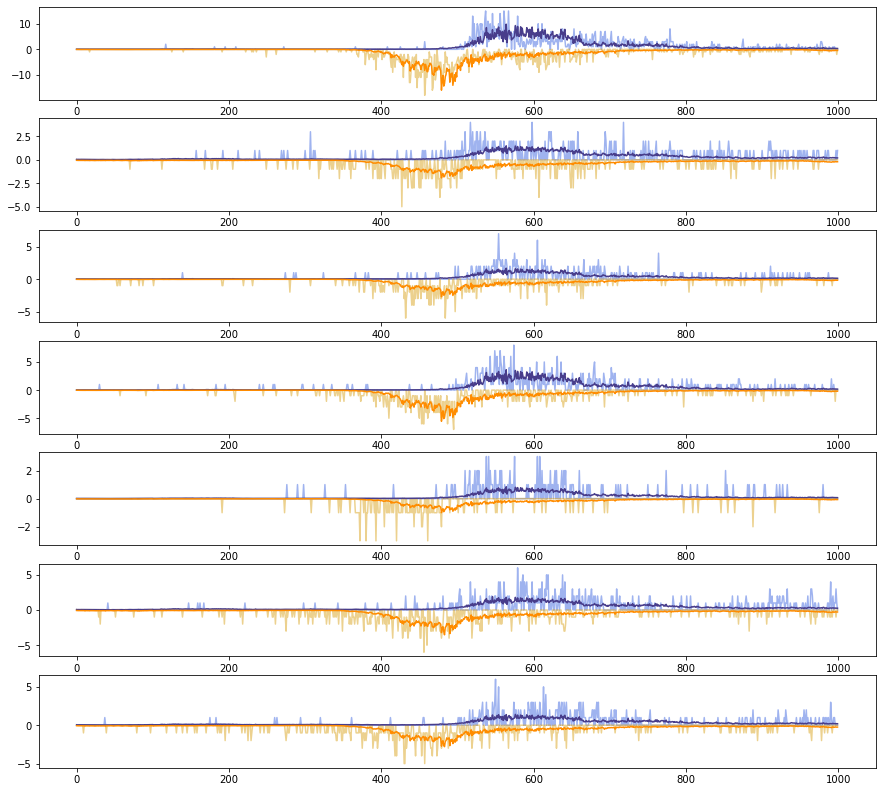

In [10]:
plot_best_unique_intervals(pred_reader, sorted_peak_inds, 5)